**Troisième réseau** :  
     - Similaire au **Premier réseau**, mais cette fois, il vise à prédire trois classes au lieu de deux.
     - Objectif : prédire si un patient est sain ou atteint de pneumonie.  
     - Architecture basée sur des couches Conv2D et MaxPooling2D pour extraire les caractéristiques des images.  
     - Entraînement sur des images brutes redimensionnées à 16x16 pixels.  
     - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 3
epochs = 50
crossValidationSplit = 10
# Scaling input image to theses dimensions
img_rows, img_cols = 16, 16

In [2]:
def preprocesar_imagen(imagen_path):
    # Cargar la imagen utilizando OpenCV
    imagen = cv2.imread(imagen_path)

    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    #alpha = 1.3  # factor de contraste
    #beta = -80    # factor de brillo
    #imagen_ajustada = cv2.convertScaleAbs(imagen_gris, alpha=alpha, beta=beta)

    imagen_final = cv2.resize(imagen_gris, (img_rows, img_cols), interpolation=cv2.INTER_AREA)

    return imagen_final


In [3]:
def load_data(ruta):
    name_classes = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']
    X, y = [], []

    # Listar las carpetas principales
    base_dirs = [ruta + r'\train', ruta + r'\val', ruta + r'\test']

    for base_dir in base_dirs:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            path = rf'{base_dir}\{class_name}\*.jpeg'
            for filename in glob.glob(path):
                im = preprocesar_imagen(filename)
                X.append(image.img_to_array(im))
                
                if class_name == 'NORMAL':
                    y.append(0)  # Clase 0: NORMAL
                elif 'bacteria' in filename.lower():
                    y.append(1)  # Clase 1: PNEUMONIA_BACTERIA
                elif 'virus' in filename.lower():
                    y.append(2)  # Clase 2: PNEUMONIA_VIRUS

    input_shape = (img_rows, img_cols, 1)
    return np.array(X), np.array(y), input_shape


In [4]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [5]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [7]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5856, 16, 16, 1) échantillons d'entraînement
16 x 16 taille de l'image
(16, 16, 1) input_shape
50 epochs


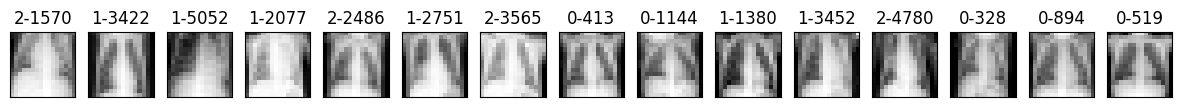

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4896 - loss: 1.0397 - val_accuracy: 0.5563 - val_loss: 0.9770
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6493 - loss: 0.7884 - val_accuracy: 0.6672 - val_loss: 0.7228
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.7044 - loss: 0.6618 - val_accuracy: 0.7048 - val_loss: 0.6521
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.7106 - loss: 0.6246 - val_accuracy: 0.7099 - val_loss: 0.6117
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.7366 - loss: 0.5813 - val_accuracy: 0.7372 - val_loss: 0.5931
Epoch 6/50
83/83 - 1s - 7ms/step - accuracy: 0.7543 - loss: 0.5631 - val_accuracy: 0.7491 - val_loss: 0.5703
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7679 - loss: 0.5335 - val_accuracy: 0.7645 - val_loss: 0.5418
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.7753 - loss: 0.5267 - val_accuracy: 0.7747 - val_loss: 0.5316
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.7712 - loss: 0.5273 - val_accuracy: 0.7969 - val_loss: 0.5163
Epoch 10/50
8

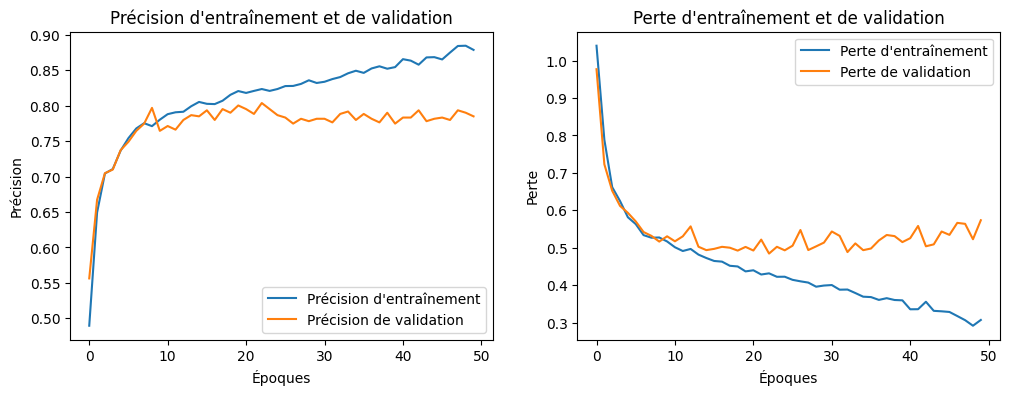

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8148 - loss: 0.5004 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Partition numéro 1:
perte: 0.57 précision: 0.78
AUC 0.9161
Prédictions
Counter({np.int64(1): 299, np.int64(2): 149, np.int64(0): 138}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.95      0.82      0.88       159
Pneumonia_bacteriana       0.79      0.85      0.82       278
     Pneumonia_viral       0.62      0.62      0.62       149

            accuracy                           0.78       586
           macro avg       0.79      0.76      0.77       586
        weighted avg       0.79      0.78      0.79       586

Matrice de confusion


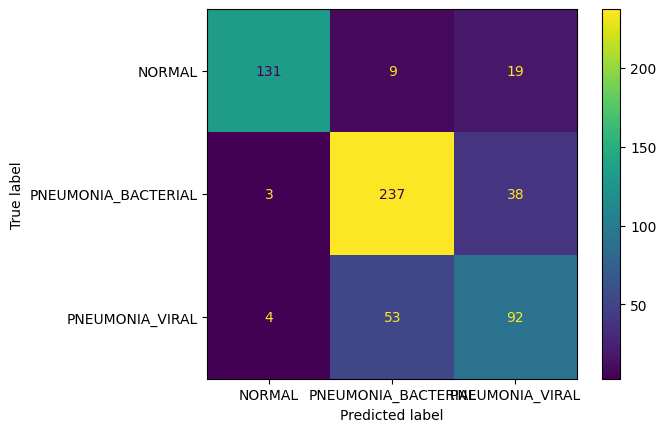

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 26ms/step - accuracy: 0.4791 - loss: 1.0396 - val_accuracy: 0.6451 - val_loss: 0.8658
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6499 - loss: 0.7888 - val_accuracy: 0.6485 - val_loss: 0.7849
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.6884 - loss: 0.6935 - val_accuracy: 0.7338 - val_loss: 0.6062
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7104 - loss: 0.6441 - val_accuracy: 0.7321 - val_loss: 0.6113
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7254 - loss: 0.6131 - val_accuracy: 0.7457 - val_loss: 0.5944
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7459 - loss: 0.5869 - val_accuracy: 0.7679 - val_loss: 0.5501
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7537 - loss: 0.5707 - val_accuracy: 0.7799 - val_loss: 0.5137
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7731 - loss: 0.5410 - val_accuracy: 0.8072 - val_loss: 0.4851
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7759 - loss: 0.5336 - val_accuracy: 0.7747 - val_loss: 0.5433
Epoch 10/50
8

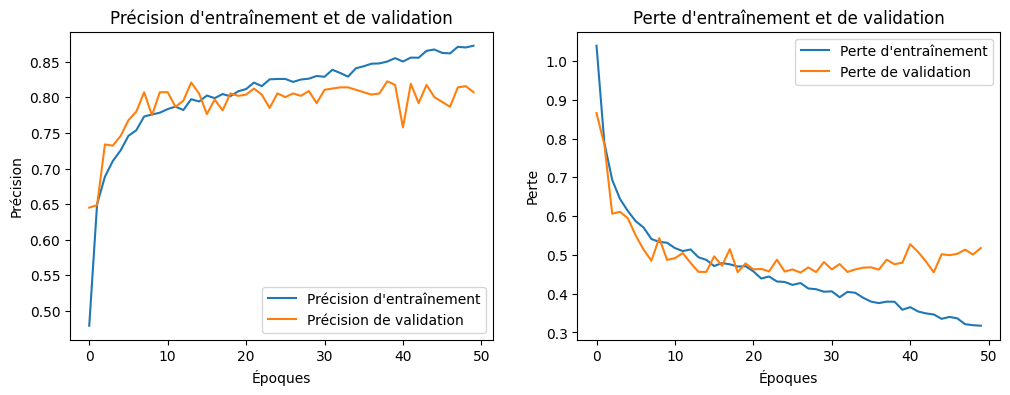

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.4228 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 2:
perte: 0.52 précision: 0.81
AUC 0.9183
Prédictions
Counter({np.int64(1): 283, np.int64(0): 161, np.int64(2): 142}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.91      0.92      0.92       159
Pneumonia_bacteriana       0.83      0.84      0.83       278
     Pneumonia_viral       0.65      0.62      0.63       149

            accuracy                           0.81       586
           macro avg       0.80      0.79      0.80       586
        weighted avg       0.80      0.81      0.81       586

Matrice de confusion


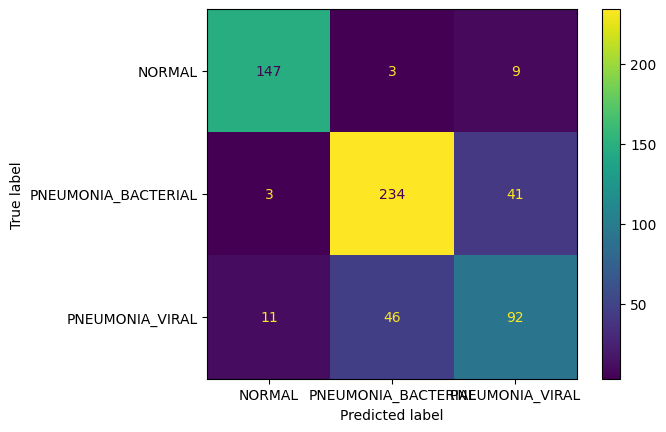

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4780 - loss: 1.0532 - val_accuracy: 0.4812 - val_loss: 0.9956
Epoch 2/50
83/83 - 1s - 6ms/step - accuracy: 0.6385 - loss: 0.8114 - val_accuracy: 0.6809 - val_loss: 0.7029
Epoch 3/50
83/83 - 1s - 6ms/step - accuracy: 0.6932 - loss: 0.6823 - val_accuracy: 0.6877 - val_loss: 0.6892
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.7123 - loss: 0.6430 - val_accuracy: 0.6706 - val_loss: 0.7019
Epoch 5/50
83/83 - 1s - 6ms/step - accuracy: 0.7213 - loss: 0.6206 - val_accuracy: 0.6962 - val_loss: 0.6736
Epoch 6/50
83/83 - 1s - 7ms/step - accuracy: 0.7351 - loss: 0.6045 - val_accuracy: 0.7065 - val_loss: 0.6351
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7419 - loss: 0.5873 - val_accuracy: 0.7406 - val_loss: 0.5952
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7579 - loss: 0.5628 - val_accuracy: 0.7116 - val_loss: 0.6342
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.7626 - loss: 0.5481 - val_accuracy: 0.7321 - val_loss: 0.6006
Epoch 10/50
8

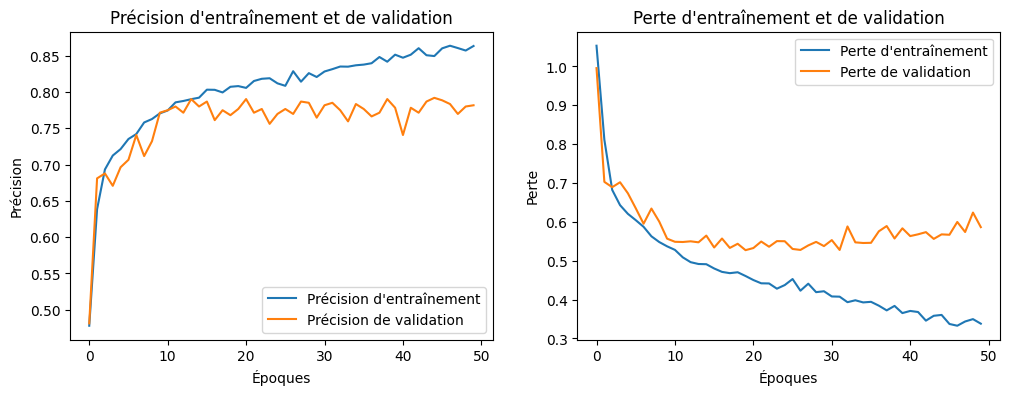

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8293 - loss: 0.4632 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 3:
perte: 0.59 précision: 0.78
AUC 0.9024
Prédictions
Counter({np.int64(1): 306, np.int64(0): 165, np.int64(2): 115}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.88      0.91      0.90       159
Pneumonia_bacteriana       0.78      0.86      0.82       278
     Pneumonia_viral       0.64      0.50      0.56       149

            accuracy                           0.78       586
           macro avg       0.77      0.76      0.76       586
        weighted avg       0.77      0.78      0.77       586

Matrice de confusion


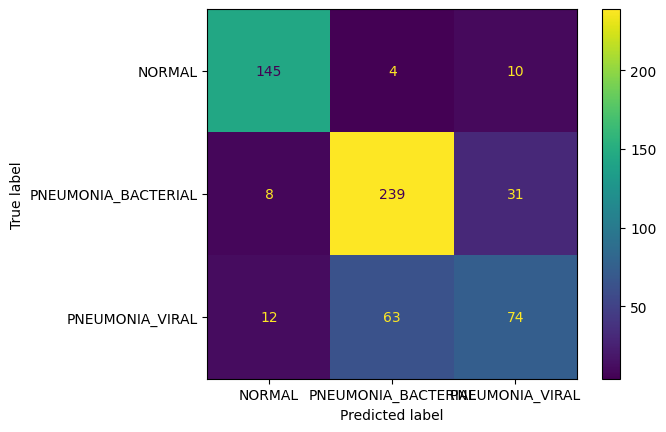

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 32ms/step - accuracy: 0.4702 - loss: 1.0575 - val_accuracy: 0.5137 - val_loss: 0.9891
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6326 - loss: 0.8195 - val_accuracy: 0.6860 - val_loss: 0.6962
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.6917 - loss: 0.6924 - val_accuracy: 0.7167 - val_loss: 0.6242
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7070 - loss: 0.6503 - val_accuracy: 0.6826 - val_loss: 0.7019
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7180 - loss: 0.6342 - val_accuracy: 0.7423 - val_loss: 0.5827
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7342 - loss: 0.6002 - val_accuracy: 0.7235 - val_loss: 0.6070
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7408 - loss: 0.5870 - val_accuracy: 0.7474 - val_loss: 0.5567
Epoch 8/50
83/83 - 1s - 6ms/step - accuracy: 0.7444 - loss: 0.5816 - val_accuracy: 0.7509 - val_loss: 0.5544
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7522 - loss: 0.5671 - val_accuracy: 0.7491 - val_loss: 0.5399
Epoch 10/50
8

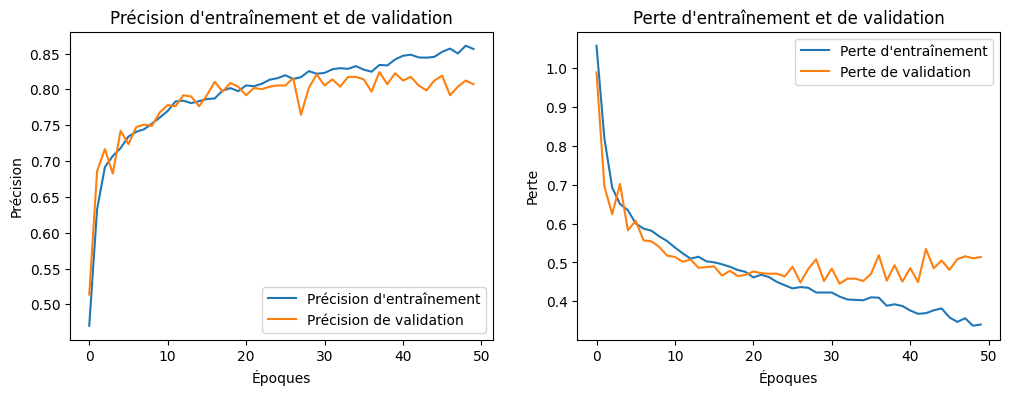

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.4202 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 4:
perte: 0.51 précision: 0.81
AUC 0.9247
Prédictions
Counter({np.int64(1): 293, np.int64(0): 157, np.int64(2): 136}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.93      0.92      0.93       158
Pneumonia_bacteriana       0.81      0.85      0.83       278
     Pneumonia_viral       0.67      0.61      0.64       150

            accuracy                           0.81       586
           macro avg       0.80      0.79      0.80       586
        weighted avg       0.80      0.81      0.80       586

Matrice de confusion


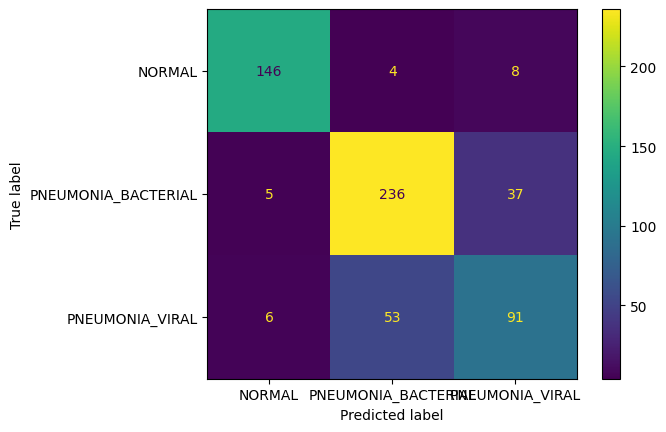

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 26ms/step - accuracy: 0.4708 - loss: 1.0567 - val_accuracy: 0.4795 - val_loss: 0.9838
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6256 - loss: 0.8486 - val_accuracy: 0.6911 - val_loss: 0.6823
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.6806 - loss: 0.7031 - val_accuracy: 0.7201 - val_loss: 0.6197
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.7042 - loss: 0.6574 - val_accuracy: 0.7065 - val_loss: 0.6154
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.7180 - loss: 0.6294 - val_accuracy: 0.7116 - val_loss: 0.6074
Epoch 6/50
83/83 - 1s - 7ms/step - accuracy: 0.7275 - loss: 0.6108 - val_accuracy: 0.7662 - val_loss: 0.5661
Epoch 7/50
83/83 - 1s - 7ms/step - accuracy: 0.7400 - loss: 0.5943 - val_accuracy: 0.7253 - val_loss: 0.5779
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.7560 - loss: 0.5677 - val_accuracy: 0.7816 - val_loss: 0.5245
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.7638 - loss: 0.5576 - val_accuracy: 0.7713 - val_loss: 0.5358
Epoch 10/50
8

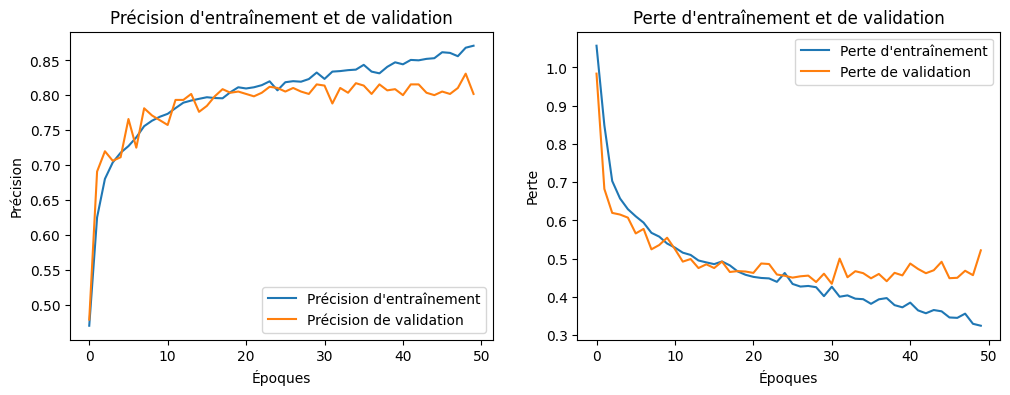

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8205 - loss: 0.5085 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 5:
perte: 0.52 précision: 0.80
AUC 0.9261
Prédictions
Counter({np.int64(1): 309, np.int64(0): 143, np.int64(2): 134}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.97      0.88      0.92       158
Pneumonia_bacteriana       0.79      0.88      0.83       278
     Pneumonia_viral       0.65      0.58      0.61       150

            accuracy                           0.80       586
           macro avg       0.80      0.78      0.79       586
        weighted avg       0.80      0.80      0.80       586

Matrice de confusion


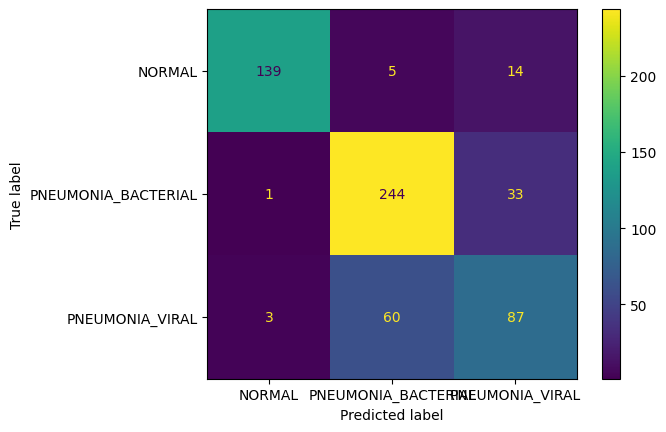

x_train (5270, 16, 16, 1) x_test (586, 16, 16, 1)
y_train (5270,) y_test (586,)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_15 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4844 - loss: 1.0430 - val_accuracy: 0.5034 - val_loss: 0.9658
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6503 - loss: 0.7841 - val_accuracy: 0.7048 - val_loss: 0.6530
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.7038 - loss: 0.6758 - val_accuracy: 0.7218 - val_loss: 0.6273
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7142 - loss: 0.6346 - val_accuracy: 0.7287 - val_loss: 0.5858
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7334 - loss: 0.6052 - val_accuracy: 0.7201 - val_loss: 0.6348
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7406 - loss: 0.5815 - val_accuracy: 0.7765 - val_loss: 0.5482
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7634 - loss: 0.5531 - val_accuracy: 0.7935 - val_loss: 0.5046
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7670 - loss: 0.5374 - val_accuracy: 0.7935 - val_loss: 0.5014
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7776 - loss: 0.5238 - val_accuracy: 0.7986 - val_loss: 0.5153
Epoch 10/50
8

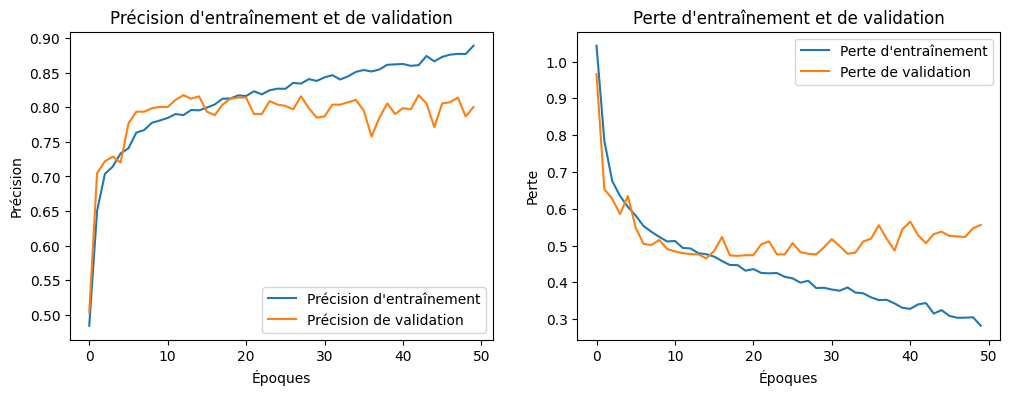

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8472 - loss: 0.4522 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 6:
perte: 0.56 précision: 0.80
AUC 0.9208
Prédictions
Counter({np.int64(1): 265, np.int64(0): 180, np.int64(2): 141}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.84      0.96      0.89       158
Pneumonia_bacteriana       0.85      0.81      0.83       278
     Pneumonia_viral       0.65      0.61      0.63       150

            accuracy                           0.80       586
           macro avg       0.78      0.79      0.79       586
        weighted avg       0.80      0.80      0.80       586

Matrice de confusion


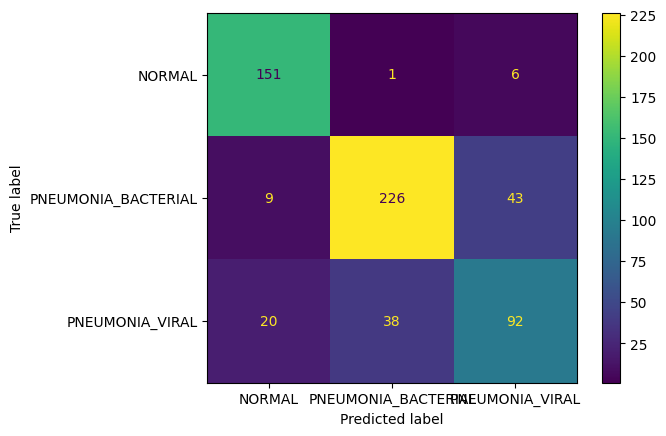

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_16 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4775 - loss: 1.0507 - val_accuracy: 0.5419 - val_loss: 0.9350
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6416 - loss: 0.8078 - val_accuracy: 0.6906 - val_loss: 0.6572
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.6993 - loss: 0.6763 - val_accuracy: 0.7385 - val_loss: 0.5995
Epoch 4/50
83/83 - 1s - 6ms/step - accuracy: 0.7057 - loss: 0.6428 - val_accuracy: 0.7368 - val_loss: 0.5652
Epoch 5/50
83/83 - 1s - 6ms/step - accuracy: 0.7376 - loss: 0.5988 - val_accuracy: 0.7778 - val_loss: 0.5316
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7509 - loss: 0.5652 - val_accuracy: 0.7744 - val_loss: 0.5051
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7596 - loss: 0.5638 - val_accuracy: 0.7829 - val_loss: 0.5012
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7742 - loss: 0.5377 - val_accuracy: 0.7932 - val_loss: 0.4918
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7778 - loss: 0.5203 - val_accuracy: 0.7692 - val_loss: 0.5034
Epoch 10/50
8

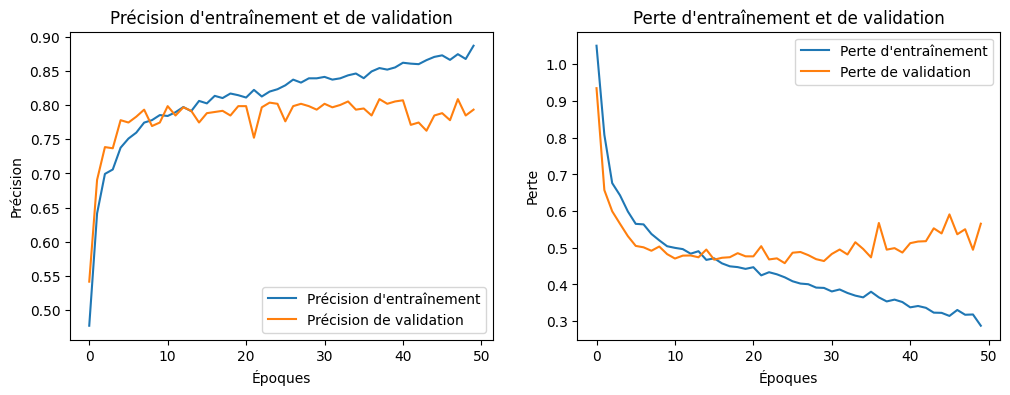

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8254 - loss: 0.5091 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 7:
perte: 0.57 précision: 0.79
AUC 0.9080
Prédictions
Counter({np.int64(1): 280, np.int64(2): 153, np.int64(0): 152}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.95      0.91      0.93       158
Pneumonia_bacteriana       0.81      0.81      0.81       278
     Pneumonia_viral       0.61      0.63      0.62       149

            accuracy                           0.79       585
           macro avg       0.79      0.79      0.79       585
        weighted avg       0.80      0.79      0.79       585

Matrice de confusion


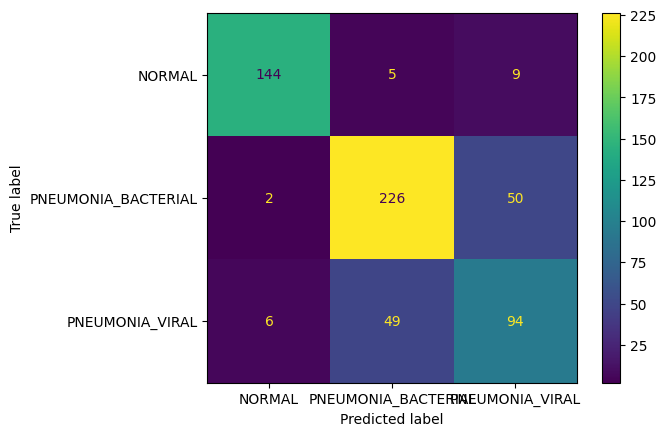

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.4751 - loss: 1.0529 - val_accuracy: 0.6393 - val_loss: 1.0025
Epoch 2/50
83/83 - 1s - 6ms/step - accuracy: 0.6338 - loss: 0.8261 - val_accuracy: 0.6752 - val_loss: 0.7248
Epoch 3/50
83/83 - 1s - 6ms/step - accuracy: 0.6970 - loss: 0.6788 - val_accuracy: 0.7026 - val_loss: 0.6307
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7076 - loss: 0.6567 - val_accuracy: 0.7453 - val_loss: 0.5926
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7348 - loss: 0.5932 - val_accuracy: 0.7385 - val_loss: 0.5946
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7547 - loss: 0.5726 - val_accuracy: 0.7641 - val_loss: 0.5550
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7693 - loss: 0.5488 - val_accuracy: 0.7641 - val_loss: 0.5537
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7723 - loss: 0.5299 - val_accuracy: 0.7709 - val_loss: 0.5417
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7837 - loss: 0.5186 - val_accuracy: 0.7795 - val_loss: 0.5325
Epoch 10/50
8

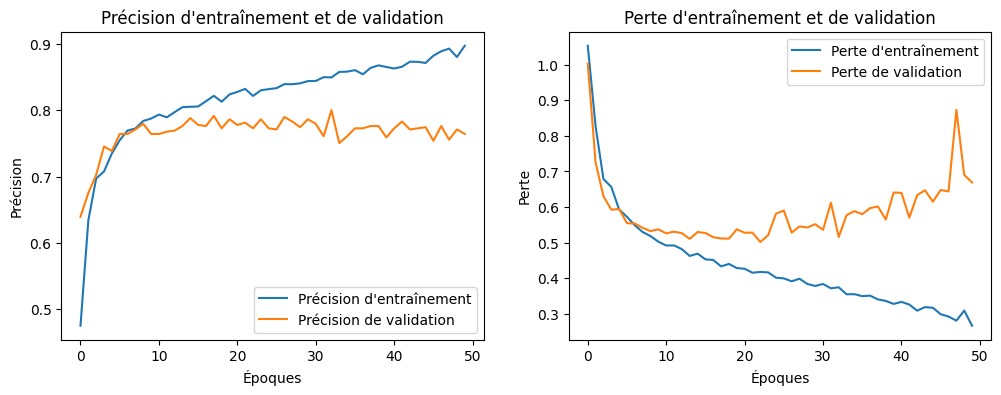

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8177 - loss: 0.4984 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 8:
perte: 0.67 précision: 0.76
AUC 0.8930
Prédictions
Counter({np.int64(1): 279, np.int64(0): 154, np.int64(2): 152}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.92      0.89      0.90       158
Pneumonia_bacteriana       0.79      0.79      0.79       278
     Pneumonia_viral       0.57      0.58      0.57       149

            accuracy                           0.76       585
           macro avg       0.76      0.75      0.76       585
        weighted avg       0.77      0.76      0.77       585

Matrice de confusion


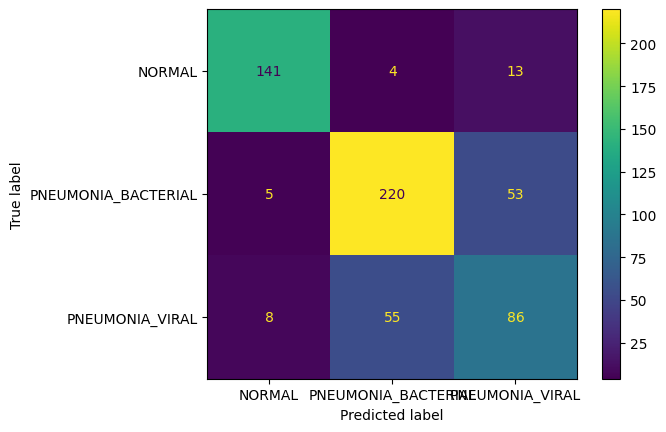

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.4794 - loss: 1.0522 - val_accuracy: 0.5214 - val_loss: 0.9520
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.6412 - loss: 0.8058 - val_accuracy: 0.6051 - val_loss: 0.8749
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.6904 - loss: 0.6843 - val_accuracy: 0.6650 - val_loss: 0.7447
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.7107 - loss: 0.6440 - val_accuracy: 0.7299 - val_loss: 0.6098
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7310 - loss: 0.6093 - val_accuracy: 0.7231 - val_loss: 0.6039
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7300 - loss: 0.5971 - val_accuracy: 0.7538 - val_loss: 0.5757
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7498 - loss: 0.5684 - val_accuracy: 0.7590 - val_loss: 0.5601
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7587 - loss: 0.5460 - val_accuracy: 0.7624 - val_loss: 0.5496
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.7587 - loss: 0.5550 - val_accuracy: 0.7761 - val_loss: 0.5545
Epoch 10/50
8

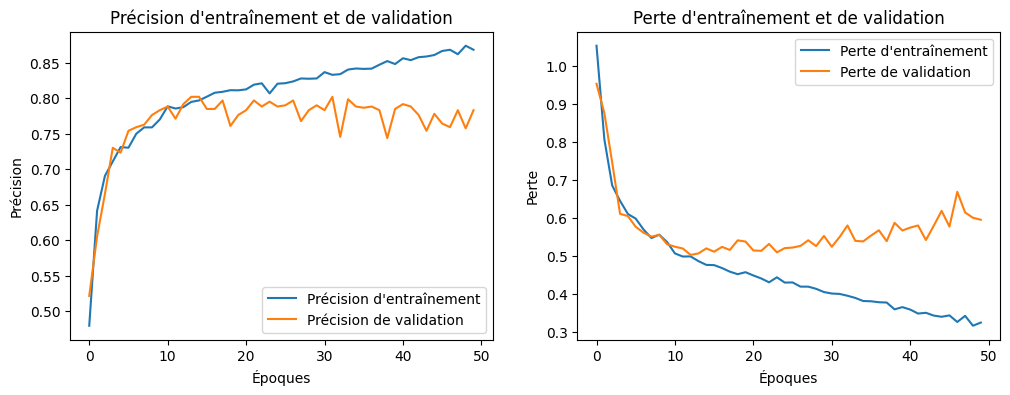

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8247 - loss: 0.4856 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 9:
perte: 0.59 précision: 0.78
AUC 0.8985
Prédictions
Counter({np.int64(1): 293, np.int64(2): 150, np.int64(0): 142}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.94      0.84      0.89       158
Pneumonia_bacteriana       0.80      0.84      0.82       278
     Pneumonia_viral       0.61      0.61      0.61       149

            accuracy                           0.78       585
           macro avg       0.78      0.76      0.77       585
        weighted avg       0.79      0.78      0.78       585

Matrice de confusion


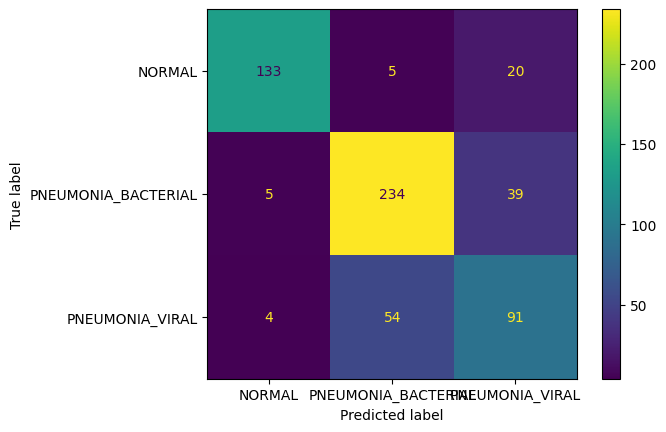

x_train (5271, 16, 16, 1) x_test (585, 16, 16, 1)
y_train (5271,) y_test (585,)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_19 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,619 (420.39 KB)

 Trainable params: 107,619 (420.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 27ms/step - accuracy: 0.4690 - loss: 1.0627 - val_accuracy: 0.4752 - val_loss: 1.0399
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.5885 - loss: 0.8904 - val_accuracy: 0.6530 - val_loss: 0.7449
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.6860 - loss: 0.6993 - val_accuracy: 0.7026 - val_loss: 0.6568
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.7090 - loss: 0.6615 - val_accuracy: 0.6957 - val_loss: 0.6722
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.7306 - loss: 0.6278 - val_accuracy: 0.7128 - val_loss: 0.6122
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.7323 - loss: 0.6013 - val_accuracy: 0.7077 - val_loss: 0.6307
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.7393 - loss: 0.5854 - val_accuracy: 0.7214 - val_loss: 0.5974
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.7644 - loss: 0.5626 - val_accuracy: 0.7419 - val_loss: 0.5895
Epoch 9/50
83/83 - 1s - 6ms/step - accuracy: 0.7545 - loss: 0.5721 - val_accuracy: 0.7453 - val_loss: 0.5737
Epoch 10/50
8

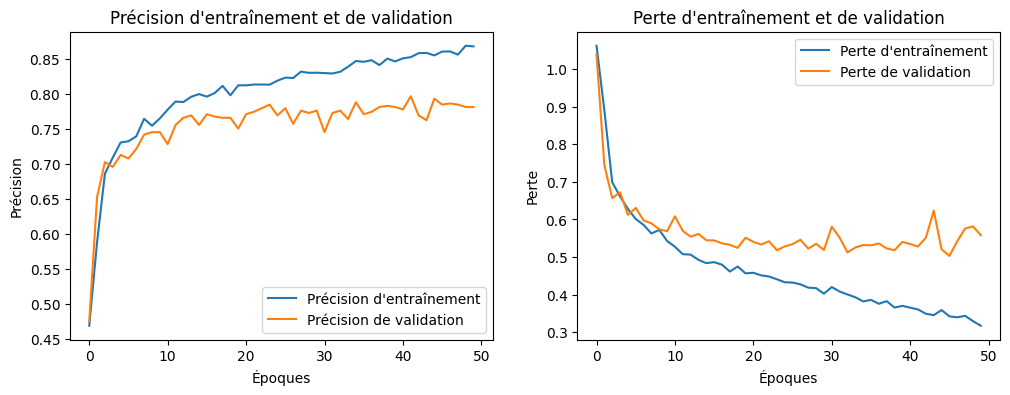

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8348 - loss: 0.4333
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 10:
perte: 0.56 précision: 0.78
AUC 0.8989
Prédictions
Counter({np.int64(1): 276, np.int64(2): 158, np.int64(0): 151}) 

Métriques
                      precision    recall  f1-score   support

              Normal       0.94      0.90      0.92       158
Pneumonia_bacteriana       0.80      0.80      0.80       278
     Pneumonia_viral       0.59      0.62      0.61       149

            accuracy                           0.78       585
           macro avg       0.78      0.77      0.78       585
        weighted avg       0.79      0.78      0.78       585

Matrice de confusion


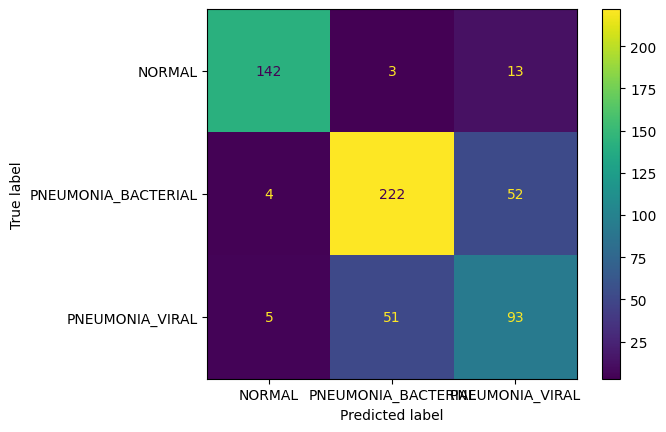

Le meilleur modèle a été sauvegardé avec un ROC de: 0.9261148830604071
Fin de l'entraînement
Résultats ROC:
0.9160992536359741

0.9182591167299674

0.902391374415167

0.9246996037542935

0.9261148830604071

0.9208289676547419

0.9079638934946707

0.8930065904146837

0.8985388164832923

0.8988817795776778

Tableau enregistré avec succès dans '2_1_resultatsROC.txt'


In [9]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = load_data(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(img_rows,'x', img_cols, 'taille de l\'image')  # Traducción: image size
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    for train_index, test_index in kf.split(X, y):
       # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)
        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia_bacteriana', 'Pneumonia_viral']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA_BACTERIAL','PNEUMONIA_VIRAL']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc_3_1.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "2_1_resultatsROC.txt")

if __name__ == '__main__':
    path = r"..\data\external\chest_xray"
    main(path)
